# Import Library

*   **'import os'** : Mengimpor modul os untuk berinteraksi dengan sistem operasi.
*   **'import zipfile'** : Mengimpor modul zipfile untuk mengoperasikan file ZIP.
*   **'import random'** : Mengimpor modul random untuk menghasilkan angka acak.
*   **'import shutil'** : Mengimpor modul shutil untuk melakukan operasi file dan direktori.
*   **'import matplotlib.pyplot as plt'** : Mengimpor modul matplotlib.pyplot sebagai plt, digunakan untuk membuat visualisasi grafik.
*   **'import numpy as np'** : Mengimpor modul numpy sebagai np, digunakan untuk operasi array numerik.
*   **'import tensorflow as tf'** : Mengimpor modul tensorflow sebagai tf, digunakan untuk membangun dan melatih model machine learning.
*   **'import pandas as pd'** : Mengimpor modul pandas sebagai pd, digunakan untuk manipulasi dan analisis data.





In [1]:
import os
import zipfile
import random
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Concatenate, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


# Mount Google Drive dan Load Data

Melakukan mount Google Drive pada Google Colab untuk mengakses dan menggunakan file dan folder yang ada di Google Drive. Hal ini memberi fleksibilitas dalam berbagi data, mengimpor dan mengekspor file, serta melakukan pengolahan data yang melibatkan file di Google Drive. Proses mount Google Drive melibatkan autentikasi pengguna dan pemberian izin akses ke Google Drive.





In [2]:
# Melakukan mount pada Google Drive
drive.mount('/content/drive')

# Membuat direktori jika belum ada
os.makedirs('/content/images', exist_ok=True)

# Menentukan path file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/images.zip'

# Membuat objek zip_ref
zip_ref = zipfile.ZipFile(zip_path, 'r')

# Mengekstrak file ZIP
extract_path = '/content/images'
zip_ref.extractall(extract_path)

# Tutup objek zip_ref setelah selesai
zip_ref.close()

Mounted at /content/drive


In [3]:
# Mendefinisikan path direktori dataset
dataset_dir = os.path.join(extract_path, 'images')
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

In [4]:
list_hewan = os.listdir(dataset_dir)

# Mendefinisikan proporsi pembagian subset data
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

print(list_hewan)

['elephant', 'chicken', 'pig', 'tiger', 'monkey', 'snake', 'swan', 'horse', 'duck', 'dragonfly', 'zebra', 'goat', 'lion', 'squirrel', 'rabbit', 'bee', 'cow', 'cat', 'butterfly', 'dog']


# Split Data 
Membagi data ke Dalam Testing, Training dan Validation set secara random dengan proporsi train : val : test = 8 : 1 : 1 dan memindahkan file gambar ke direktori yang sesuai dengan subset yang tepat.

In [5]:
# Memilih secara acak file gambar untuk setiap kelas dan membaginya menjadi subset
for hewan in list_hewan:
    class_dir = os.path.join(dataset_dir, hewan)
    image_files = os.listdir(class_dir)
    random.shuffle(image_files)
    
    train_files, test_val_files = train_test_split(image_files, test_size=(val_ratio+test_ratio), random_state=42)
    val_files, test_files = train_test_split(test_val_files, test_size=test_ratio/(val_ratio+test_ratio), random_state=42)

    # Memindahkan file gambar ke subset data train, validation, dan test
    for file_name in train_files:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(train_dir, hewan, file_name)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for file_name in val_files:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(val_dir, hewan, file_name)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for file_name in test_files:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(test_dir, hewan, file_name)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

# Generator data dengan augmentasi
Generator data akan memuat dan memproses batch data gambar secara otomatis dengan augmentasi yang ditentukan.

In [6]:
# Membuat generator data dengan augmentasi
image_size = (256, 256)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8000 images belonging to 20 classes.
Found 1000 images belonging to 20 classes.
Found 1000 images belonging to 20 classes.


# Membuat Arsitektur Model
 Membuat model SSD (Single Shot MultiBox Detector) dengan menggunakan arsitektur MobileNet sebagai lapisan dalam model yang lebih besar untuk melakukan klasifikasi gambar.



In [7]:
# Membuat model SSD MobileNet sebagai lapisan dalam model yang lebih besar
def create_model():
    # Input tensor dengan ukuran yang sesuai
    input_tensor = Input(shape=(256, 256, 3))

    # Membuat model MobileNetV2 tanpa kelas top
    base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    # Mengambil keluaran beberapa layer yang sesuai
    layer_outputs = [
        base_model.get_layer('block_6_expand_relu').output,
        base_model.get_layer('block_13_expand_relu').output,
        base_model.get_layer('out_relu').output,
    ]

    # Menyesuaikan dimensi lapisan keluaran
    adjusted_layer_outputs = []
    for layer_output in layer_outputs:
        adjusted_layer_output = Conv2D(256, (1, 1), activation='relu')(layer_output)
        adjusted_layer_output = GlobalAveragePooling2D()(adjusted_layer_output)
        adjusted_layer_outputs.append(adjusted_layer_output)

    # Menggabungkan semua keluaran layer dalam satu tensor
    concat_tensor = Concatenate()(adjusted_layer_outputs)

    # Menambahkan layer Dense tambahan
    dense_layer1 = Dense(256, activation='relu')(concat_tensor)
    flatten_layer = Flatten()(dense_layer1)
    dropout_layer1 = Dropout(0.5)(flatten_layer)
    dense_layer2 = Dense(512, activation='relu')(dropout_layer1)
    dropout_layer2 = Dropout(0.5)(dense_layer2)
    dense_layer3 = Dense(128, activation='relu')(dropout_layer2)
    dropout_layer3 = Dropout(0.5)(dense_layer3)
    dense_layer3 = Dense(64, activation='relu')(dropout_layer3)
    output_layer = Dense(20, activation='softmax')(dense_layer3)

    # Membuat model akhir dengan input dan output tensor yang sesuai
    model = Model(inputs=input_tensor, outputs=output_layer)

    return model

# Membuat model dengan menggunakan fungsi yang telah didefinisikan
ssd_model = create_model()

# Mengimport modul optimizer dari TensorFlow
optimizer = optimizers.Adam(learning_rate=1e-4)

# Mengompilasi model dengan optimizer yang telah dimodifikasi
ssd_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 1s 0us/step


Menampilkan ringkasan (summary) dari arsitektur model SSD MobileNetV2 yang telah dibuat. Ringkasan ini memberikan informasi tentang lapisan-lapisan dalam model beserta jumlah parameter yang digunakan pada setiap lapisan.

In [8]:
ssd_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                             

# Checkpoint dan CSVLogger
Menggunakan checkpoint untuk menyimpan model yang sedang dilatih selama training berlangsung. Checkpoint disimpan pada drive dan berguna untuk memastikan bahwa model yang dilatih dapat disimpan dan dipulihkan pada titik tertentu, sehingga tidak perlu melatih ulang model dari awal jika terjadi kesalahan atau jika pelatihan terputus. 

In [9]:
# Mendefinisikan path untuk menyimpan checkpoint
checkpoint_path = '/content/drive/MyDrive/checkpoints/model_ssd.h5'

# Membuat callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_accuracy',  # Menyimpan berdasarkan val_loss
                                      save_best_only=True,  # Hanya menyimpan model terbaik
                                      save_weights_only=False,  # Menyimpan seluruh model (termasuk arsitektur)
                                      mode='max', # Menyimpan model hanya jika nilai metrik tersebut meningkat
                                      verbose=1)  # Menampilkan pesan saat menyimpan


Menggunakan CSVlogger untuk mencatat log pelatihan dalam format CSV. CSVLogger akan digunakan sebagai callback saat melatih model untuk mencatat metrik pelatihan, seperti loss dan akurasi, ke dalam file log CSV yang spesifik.






In [10]:
# Mendefinisikan path direktori training
training_dir = '/content/drive/MyDrive/training'

# Membuat direktori training jika belum ada
os.makedirs(training_dir, exist_ok=True)

# Path untuk file log training
log_path = os.path.join(training_dir, 'trainingssd.log')

# Membuat objek CSVLogger dengan path log yang sudah ditentukan
csv_logger = tf.keras.callbacks.CSVLogger(log_path)

Model Checkpoint akan menyimpan model pada titik-titik tertentu selama pelatihan berdasarkan kriteria yang telah ditentukan, sedangkan CSVLogger akan mencatat log pelatihan ke dalam file log CSV.

# Pelatihan Model
Melatih model menggunakan data pelatihan dan dievaluasi menggunakan data validasi, sambil mencatat metrik pelatihan dan validasi seperti akurasi dan loss pada setiap epoch.

In [11]:
ssd_history = ssd_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=25,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[checkpoint_callback, csv_logger],  # Menambahkan csv_logger ke dalam callbacks
)

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 2.8630 - accuracy: 0.1103
Epoch 1: val_accuracy improved from -inf to 0.46069, saving model to /content/drive/MyDrive/checkpoints/model_ssd.h5
250/250 [==============================] - 209s 651ms/step - loss: 2.8630 - accuracy: 0.1103 - val_loss: 1.9734 - val_accuracy: 0.4607
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 1.8388 - accuracy: 0.4055
Epoch 2: val_accuracy improved from 0.46069 to 0.77520, saving model to /content/drive/MyDrive/checkpoints/model_ssd.h5
250/250 [==============================] - 160s 640ms/step - loss: 1.8388 - accuracy: 0.4055 - val_loss: 0.8940 - val_accuracy: 0.7752
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 1.0336 - accuracy: 0.6706
Epoch 3: val_accuracy improved from 0.77520 to 0.87399, saving model to /content/drive/MyDrive/checkpoints/model_ssd.h5
250/250 [==============================] - 161s 643ms/step - loss: 1.0336 - accuracy:

# Learning Curve
Menampilkan grafik yang menunjukkan perubahan akurasi dan loss pada training set dan validation set seiring dengan jumlah epoch yang dilakukan selama proses pelatihan model.

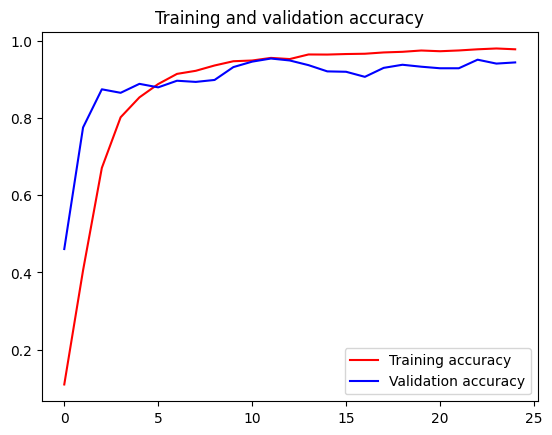

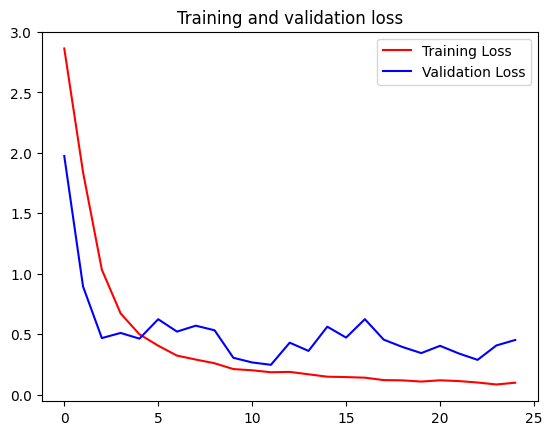

In [12]:
# Plot the chart for accuracy and loss on both training and validation
acc = ssd_history.history['accuracy']
val_acc = ssd_history.history['val_accuracy']
loss = ssd_history.history['loss']
val_loss = ssd_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluasi Model Menggunakan Data Uji
Melakukan evaluasi model menggunakan data uji untuk mendapatkan informasi tentang kinerja model pada data uji, termasuk akurasi, presisi, recall, F1-score, loss, dan akurasi pada data uji

In [13]:
# Path ke direktori data uji
test_dir = '/content/images/images/test'

# Inisialisasi objek ImageDataGenerator untuk data uji
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator data uji
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Menghitung metrik-metrik menggunakan metode evaluate dari model
test_loss, test_accuracy = ssd_model.evaluate(test_generator, verbose=0)
predictions = ssd_model.predict(test_generator)
true_labels = test_generator.classes
prediction_labels = np.argmax(predictions, axis=1)

# Menghitung metrik-metrik
accuracy = accuracy_score(true_labels, prediction_labels)
precision = precision_score(true_labels, prediction_labels, average='weighted')
recall = recall_score(true_labels, prediction_labels, average='weighted')
f1 = f1_score(true_labels, prediction_labels, average='weighted')

# Menampilkan metrik
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 1000 images belonging to 20 classes.
32/32 [==============================] - 4s 114ms/step
Accuracy: 0.935
Precision: 0.9382561637059456
Recall: 0.935
F1 Score: 0.9348497069358569
Test Loss: 0.48698174953460693
Test Accuracy: 0.9350000023841858


# Matriks Konfusi
Mendapatkan visualisasi matriks konfusi yang memperlihatkan prediksi yang benar dan salah untuk setiap kelas.

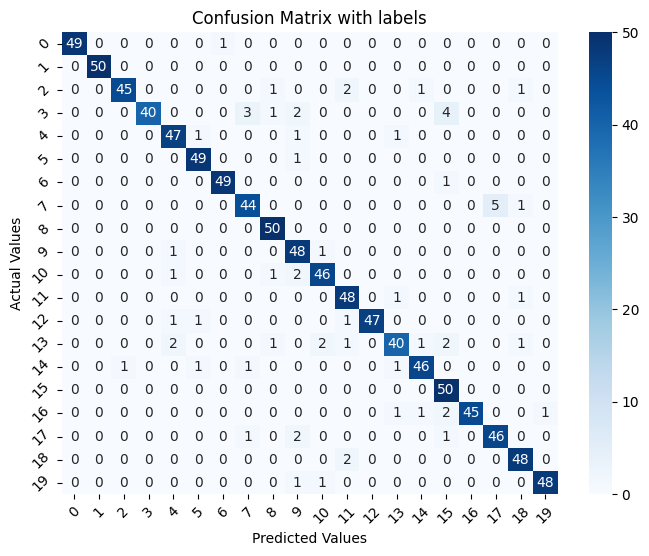

In [15]:
#matriks konfusi
cf_matrix = confusion_matrix(true_labels, prediction_labels)

# Create the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)

# Set labels and title
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Set tick labels
label_types = sorted(list(set(true_labels)))  # List of unique label types sorted alphabetically
ax.xaxis.set_ticklabels(label_types, rotation=45)
ax.yaxis.set_ticklabels(label_types, rotation=45)

# Display the visualization of the Confusion Matrix
plt.show()

# Menyimpan Model 
Menyimpan model dalam format H5 (Hierarchical Data Format) dan TFLite (TensorFlow Lite). Format H5 digunakan untuk menyimpan model yang lengkap, termasuk arsitektur, bobot, dan konfigurasi model. Format TFLite adalah format yang dioptimalkan untuk menjalankan model pada perangkat dengan sumber daya terbatas seperti perangkat seluler, sistem embedded, atau IoT (Internet of Things).

In [25]:
# Save model H5
ssd_model.save('/content/drive/MyDrive/models/model_ssd.h5')

In [26]:
# Save model TF
ssd_model.save('/content/drive/MyDrive/models/model_ssd')

In [27]:
import pathlib

# TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/models/model_ssd')
converter.optimization = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert();

tflite_model_file = pathlib.Path('/content/drive/MyDrive/models/model_ssd.tflite')
tflite_model_file.write_bytes(tflite_model)

12576300